In [46]:
import numpy as np
import tensorflow as tf

import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import f1_score

import optuna

print(optuna.__version__)

3.6.1


In [47]:
data = pd.read_csv("../../data/labels_features.csv")
X = data.iloc[:, 2:-1].to_numpy()
Y = data["MFS_cens"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42,stratify=Y
)


def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.02))


scheduler = LearningRateScheduler(custom_scheduler)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
)

model_save = ModelCheckpoint(
    "../../models/optimizers/hyperparam_best_model.h5",
    save_best_only=True,
    mode="max",
    monitor="val_accuracy",
    initial_value_threshold=0.85,
    verbose=0,
)


normalizer = layers.Normalization()
normalizer.adapt(X)

In [48]:
import tensorflow as tf
from sklearn.metrics import f1_score

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)  # Zakładamy, że y_pred jest wartościami kontinuacyjnymi, a nie binarnymi
    
    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum(y_pred) - TP
    FN = tf.reduce_sum(y_true) - TP
    
    precision = TP / (TP + FP + tf.keras.backend.epsilon())
    recall = TP / (TP + FN + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

# Definicja funkcji celu
def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    batch_size = trial.suggest_categorical("batch_size", [4, 64])

    n_1_layers = trial.suggest_int("n_1_layers", 1, 3)
    n_2_layers = trial.suggest_int("n_2_layers", 1, 3)
    n_layers_dense = trial.suggest_int("n_layers_dense", 1, 3)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((x_train.shape[1], 1)))

    for i in range(n_1_layers):
        num_neurons_conv_1 = trial.suggest_int(f"n_1_units_l_{i}", 64, 512, log=True)
        model.add(tf.keras.layers.Conv1D(num_neurons_conv_1, 1, activation="relu"))

    model.add(tf.keras.layers.MaxPooling1D())

    for i in range(n_2_layers):
        num_neurons_conv_2 = trial.suggest_int(f"n_2_units_l_{i}", 64, 512, log=True)
        model.add(tf.keras.layers.Conv1D(num_neurons_conv_2, 1, activation="relu"))
        
    model.add(tf.keras.layers.MaxPooling1D())

    model.add(tf.keras.layers.Flatten())

    for i in range(n_layers_dense):
        num_neurons_dense = trial.suggest_int(f"n_3_units_l_{i}", 64, 512, log=True)
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(num_neurons_dense, activation="relu"))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[f1_score]
    )

    # Trenowanie modelu
    history = model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        verbose=0
    )

    # Obliczenie F1-score na zbiorze testowym
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1score = f1_score(y_test, y_pred_binary)

    return f1score

# Optymalizacja za pomocą Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=80)

# Wyświetlenie najlepszych parametrów
print("Best trial:")
trial = study.best_trial
print("\tValue: {}".format(trial.value))
print("\tParams:")
for key, value in trial.params.items():
    print("\t\t{}:   \t{}".format(key, value))


[I 2024-06-18 01:39:23,997] A new study created in memory with name: no-name-64166fe0-fbed-48d2-9f54-1d570aaefd0c


1/1 [==============================] - 0s 85ms/step


[I 2024-06-18 01:39:28,039] Trial 0 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.24079024023879678, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 485, 'n_2_units_l_0': 118, 'n_3_units_l_0': 87, 'n_3_units_l_1': 242}. Best is trial 0 with value: 21.955554962158203.


1/1 [==============================] - 0s 104ms/step


[I 2024-06-18 01:39:34,533] Trial 1 finished with value: 19.487178802490234 and parameters: {'dropout_rate': 0.13036521355624922, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 481, 'n_1_units_l_1': 136, 'n_1_units_l_2': 386, 'n_2_units_l_0': 92, 'n_3_units_l_0': 387, 'n_3_units_l_1': 116}. Best is trial 0 with value: 21.955554962158203.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:39:41,808] Trial 2 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.15650063875581377, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 216, 'n_2_units_l_0': 80, 'n_2_units_l_1': 421, 'n_2_units_l_2': 137, 'n_3_units_l_0': 199, 'n_3_units_l_1': 64}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 75ms/step


[I 2024-06-18 01:39:48,286] Trial 3 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3465325315995201, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 1, 'n_1_units_l_0': 68, 'n_2_units_l_0': 277, 'n_3_units_l_0': 265}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 100ms/step


[I 2024-06-18 01:39:51,439] Trial 4 finished with value: 9.119999885559082 and parameters: {'dropout_rate': 0.16984601951494735, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 136, 'n_1_units_l_1': 86, 'n_1_units_l_2': 490, 'n_2_units_l_0': 220, 'n_2_units_l_1': 378, 'n_3_units_l_0': 166}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 108ms/step


[I 2024-06-18 01:39:54,369] Trial 5 finished with value: 1.899999976158142 and parameters: {'dropout_rate': 0.35581684440695793, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 1, 'n_1_units_l_0': 245, 'n_1_units_l_1': 75, 'n_1_units_l_2': 91, 'n_2_units_l_0': 96, 'n_2_units_l_1': 98, 'n_2_units_l_2': 410, 'n_3_units_l_0': 67}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 101ms/step


[I 2024-06-18 01:39:57,287] Trial 6 finished with value: 19.950000762939453 and parameters: {'dropout_rate': 0.1945217882609473, 'batch_size': 64, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 1, 'n_1_units_l_0': 168, 'n_1_units_l_1': 385, 'n_2_units_l_0': 125, 'n_2_units_l_1': 204, 'n_2_units_l_2': 82, 'n_3_units_l_0': 492}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 98ms/step


[I 2024-06-18 01:40:02,069] Trial 7 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.28688628244264625, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 166, 'n_2_units_l_0': 282, 'n_2_units_l_1': 184, 'n_3_units_l_0': 98, 'n_3_units_l_1': 446}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 108ms/step


[I 2024-06-18 01:40:05,836] Trial 8 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.12687379588218817, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 312, 'n_1_units_l_1': 115, 'n_1_units_l_2': 247, 'n_2_units_l_0': 64, 'n_2_units_l_1': 237, 'n_2_units_l_2': 397, 'n_3_units_l_0': 282, 'n_3_units_l_1': 120}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:40:11,632] Trial 9 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.10762449766732594, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 133, 'n_1_units_l_1': 303, 'n_2_units_l_0': 255, 'n_3_units_l_0': 164, 'n_3_units_l_1': 233}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 101ms/step


[I 2024-06-18 01:40:17,030] Trial 10 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.2352008624417474, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 84, 'n_2_units_l_0': 166, 'n_2_units_l_1': 485, 'n_2_units_l_2': 123, 'n_3_units_l_0': 126, 'n_3_units_l_1': 71, 'n_3_units_l_2': 293}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 93ms/step


[I 2024-06-18 01:40:21,825] Trial 11 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3767349275664224, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 65, 'n_2_units_l_0': 470, 'n_2_units_l_1': 70, 'n_3_units_l_0': 258, 'n_3_units_l_1': 65, 'n_3_units_l_2': 69}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 84ms/step


[I 2024-06-18 01:40:30,891] Trial 12 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.3014363167171572, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 1, 'n_layers_dense': 1, 'n_1_units_l_0': 94, 'n_1_units_l_1': 227, 'n_2_units_l_0': 382, 'n_3_units_l_0': 229}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 98ms/step


[I 2024-06-18 01:40:41,780] Trial 13 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.30808322698602614, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 261, 'n_2_units_l_0': 167, 'n_2_units_l_1': 328, 'n_3_units_l_0': 338, 'n_3_units_l_1': 116, 'n_3_units_l_2': 469}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:40:46,774] Trial 14 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.1963363160506577, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 220, 'n_2_units_l_0': 328, 'n_2_units_l_1': 119, 'n_3_units_l_0': 202}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 95ms/step


[I 2024-06-18 01:40:52,676] Trial 15 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.3383984168190517, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 1, 'n_1_units_l_0': 112, 'n_1_units_l_1': 451, 'n_2_units_l_0': 64, 'n_2_units_l_1': 293, 'n_2_units_l_2': 195, 'n_3_units_l_0': 138}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 83ms/step


[I 2024-06-18 01:40:59,945] Trial 16 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.39841948943956884, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 3, 'n_1_units_l_0': 348, 'n_2_units_l_0': 202, 'n_3_units_l_0': 337, 'n_3_units_l_1': 383, 'n_3_units_l_2': 106}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:41:11,360] Trial 17 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.26827442572765653, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 70, 'n_1_units_l_1': 199, 'n_2_units_l_0': 479, 'n_2_units_l_1': 509, 'n_3_units_l_0': 203, 'n_3_units_l_1': 161}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 85ms/step


[I 2024-06-18 01:41:13,681] Trial 18 finished with value: 9.119999885559082 and parameters: {'dropout_rate': 0.16521345581245367, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 206, 'n_2_units_l_0': 139, 'n_2_units_l_1': 138, 'n_3_units_l_0': 262, 'n_3_units_l_1': 85}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 79ms/step


[I 2024-06-18 01:41:17,341] Trial 19 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3390688617120839, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 1, 'n_1_units_l_0': 360, 'n_2_units_l_0': 86, 'n_3_units_l_0': 123}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 101ms/step


[I 2024-06-18 01:41:27,933] Trial 20 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.21734398035848446, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 134, 'n_1_units_l_1': 128, 'n_2_units_l_0': 378, 'n_2_units_l_1': 278, 'n_2_units_l_2': 192, 'n_3_units_l_0': 507, 'n_3_units_l_1': 315}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 82ms/step


[I 2024-06-18 01:41:32,607] Trial 21 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.27334531663081335, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 195, 'n_2_units_l_0': 279, 'n_2_units_l_1': 162, 'n_3_units_l_0': 101, 'n_3_units_l_1': 407}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 95ms/step


[I 2024-06-18 01:41:37,708] Trial 22 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3052376775422732, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 173, 'n_2_units_l_0': 265, 'n_2_units_l_1': 189, 'n_2_units_l_2': 64, 'n_3_units_l_0': 67, 'n_3_units_l_1': 177, 'n_3_units_l_2': 166}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 77ms/step


[I 2024-06-18 01:41:41,918] Trial 23 finished with value: 21.590909957885742 and parameters: {'dropout_rate': 0.2745007817184952, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 100, 'n_2_units_l_0': 306, 'n_3_units_l_0': 87, 'n_3_units_l_1': 484}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:41:46,175] Trial 24 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3283750959879469, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 155, 'n_2_units_l_0': 225, 'n_2_units_l_1': 64, 'n_3_units_l_0': 153, 'n_3_units_l_1': 250}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 84ms/step


[I 2024-06-18 01:41:49,907] Trial 25 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3572366216109405, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 79, 'n_2_units_l_0': 183, 'n_2_units_l_1': 93, 'n_3_units_l_0': 103}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 106ms/step


[I 2024-06-18 01:41:53,072] Trial 26 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.2881392769371222, 'batch_size': 64, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 290, 'n_1_units_l_1': 66, 'n_2_units_l_0': 355, 'n_2_units_l_1': 376, 'n_2_units_l_2': 123, 'n_3_units_l_0': 205, 'n_3_units_l_1': 142, 'n_3_units_l_2': 243}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 88ms/step


[I 2024-06-18 01:42:00,959] Trial 27 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.25425947559476614, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 406, 'n_2_units_l_0': 248, 'n_2_units_l_1': 225, 'n_3_units_l_0': 290, 'n_3_units_l_1': 90}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 88ms/step


[I 2024-06-18 01:42:08,441] Trial 28 finished with value: 21.20930290222168 and parameters: {'dropout_rate': 0.31649445381130986, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 1, 'n_1_units_l_0': 109, 'n_2_units_l_0': 417, 'n_3_units_l_0': 184}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:42:12,688] Trial 29 finished with value: 21.20930290222168 and parameters: {'dropout_rate': 0.3971843875755872, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 236, 'n_2_units_l_0': 149, 'n_3_units_l_0': 80, 'n_3_units_l_1': 305}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 121ms/step


[I 2024-06-18 01:42:21,397] Trial 30 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.23733231925162052, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 146, 'n_1_units_l_1': 286, 'n_2_units_l_0': 108, 'n_2_units_l_1': 157, 'n_2_units_l_2': 265, 'n_3_units_l_0': 234, 'n_3_units_l_1': 494}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 129ms/step


[I 2024-06-18 01:42:26,085] Trial 31 finished with value: 9.119999885559082 and parameters: {'dropout_rate': 0.1351486605030158, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 308, 'n_1_units_l_1': 122, 'n_1_units_l_2': 194, 'n_2_units_l_0': 66, 'n_2_units_l_1': 227, 'n_2_units_l_2': 510, 'n_3_units_l_0': 325, 'n_3_units_l_1': 116}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 139ms/step


[I 2024-06-18 01:42:30,800] Trial 32 finished with value: 1.899999976158142 and parameters: {'dropout_rate': 0.13336632232534568, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 512, 'n_1_units_l_1': 99, 'n_1_units_l_2': 199, 'n_2_units_l_0': 78, 'n_2_units_l_1': 263, 'n_2_units_l_2': 311, 'n_3_units_l_0': 389, 'n_3_units_l_1': 88}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 111ms/step


[I 2024-06-18 01:42:35,848] Trial 33 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.10943650551831505, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 421, 'n_1_units_l_1': 160, 'n_1_units_l_2': 89, 'n_2_units_l_0': 76, 'n_2_units_l_1': 386, 'n_2_units_l_2': 140, 'n_3_units_l_0': 410, 'n_3_units_l_1': 134}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 111ms/step


[I 2024-06-18 01:42:39,697] Trial 34 finished with value: 11.259259223937988 and parameters: {'dropout_rate': 0.1587768982876616, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 281, 'n_1_units_l_1': 169, 'n_1_units_l_2': 277, 'n_2_units_l_0': 100, 'n_2_units_l_1': 246, 'n_2_units_l_2': 256, 'n_3_units_l_0': 290, 'n_3_units_l_1': 196}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 99ms/step


[I 2024-06-18 01:42:42,442] Trial 35 finished with value: 9.119999885559082 and parameters: {'dropout_rate': 0.14943204947413027, 'batch_size': 64, 'n_1_layers': 3, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 187, 'n_1_units_l_1': 114, 'n_1_units_l_2': 130, 'n_2_units_l_0': 74, 'n_2_units_l_1': 177, 'n_3_units_l_0': 180}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 98ms/step


[I 2024-06-18 01:42:45,363] Trial 36 finished with value: 9.119999885559082 and parameters: {'dropout_rate': 0.18425229185434358, 'batch_size': 64, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 1, 'n_1_units_l_0': 335, 'n_1_units_l_1': 231, 'n_2_units_l_0': 221, 'n_2_units_l_1': 134, 'n_2_units_l_2': 96, 'n_3_units_l_0': 235}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 85ms/step


[I 2024-06-18 01:42:47,667] Trial 37 finished with value: 1.899999976158142 and parameters: {'dropout_rate': 0.21608877481091276, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 3, 'n_1_units_l_0': 250, 'n_2_units_l_0': 87, 'n_3_units_l_0': 287, 'n_3_units_l_1': 94, 'n_3_units_l_2': 64}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 104ms/step


[I 2024-06-18 01:42:51,020] Trial 38 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.10318151213144078, 'batch_size': 64, 'n_1_layers': 2, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 410, 'n_1_units_l_1': 94, 'n_2_units_l_0': 196, 'n_2_units_l_1': 326, 'n_2_units_l_2': 161, 'n_3_units_l_0': 432, 'n_3_units_l_1': 77}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 92ms/step


[I 2024-06-18 01:42:58,540] Trial 39 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.1224095637990855, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 120, 'n_1_units_l_1': 161, 'n_2_units_l_0': 120, 'n_2_units_l_1': 424, 'n_3_units_l_0': 152}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 98ms/step


[I 2024-06-18 01:43:09,767] Trial 40 finished with value: 21.590909957885742 and parameters: {'dropout_rate': 0.18547016582762343, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 224, 'n_2_units_l_0': 310, 'n_2_units_l_1': 325, 'n_2_units_l_2': 365, 'n_3_units_l_0': 259, 'n_3_units_l_1': 105}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:43:16,123] Trial 41 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.1172192204638495, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 160, 'n_1_units_l_1': 272, 'n_1_units_l_2': 280, 'n_2_units_l_0': 244, 'n_3_units_l_0': 170, 'n_3_units_l_1': 208}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:43:22,051] Trial 42 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.1446211349386845, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 126, 'n_1_units_l_1': 413, 'n_2_units_l_0': 286, 'n_3_units_l_0': 123, 'n_3_units_l_1': 286}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 78ms/step


[I 2024-06-18 01:43:25,715] Trial 43 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.12019659387529208, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 83, 'n_2_units_l_0': 70, 'n_3_units_l_0': 224, 'n_3_units_l_1': 232}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 93ms/step


[I 2024-06-18 01:43:32,629] Trial 44 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3613304747077815, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 1, 'n_layers_dense': 3, 'n_1_units_l_0': 176, 'n_1_units_l_1': 339, 'n_2_units_l_0': 332, 'n_3_units_l_0': 140, 'n_3_units_l_1': 390, 'n_3_units_l_2': 469}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:43:45,295] Trial 45 finished with value: 21.590909957885742 and parameters: {'dropout_rate': 0.10069158970928815, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 64, 'n_1_units_l_1': 499, 'n_1_units_l_2': 65, 'n_2_units_l_0': 426, 'n_3_units_l_0': 313, 'n_3_units_l_1': 157}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 82ms/step


[I 2024-06-18 01:43:49,785] Trial 46 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.21644189466868516, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 205, 'n_2_units_l_0': 244, 'n_3_units_l_0': 108, 'n_3_units_l_1': 264}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 80ms/step


[I 2024-06-18 01:43:54,137] Trial 47 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.1727555988397746, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 142, 'n_2_units_l_0': 165, 'n_2_units_l_1': 203, 'n_3_units_l_0': 76}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 101ms/step


[I 2024-06-18 01:44:00,122] Trial 48 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3756834187682037, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 263, 'n_1_units_l_1': 324, 'n_2_units_l_0': 133, 'n_2_units_l_1': 101, 'n_3_units_l_0': 214, 'n_3_units_l_1': 335, 'n_3_units_l_2': 133}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 105ms/step


[I 2024-06-18 01:44:03,132] Trial 49 finished with value: 7.916666507720947 and parameters: {'dropout_rate': 0.28950633744844695, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 93, 'n_2_units_l_0': 83, 'n_2_units_l_1': 441, 'n_2_units_l_2': 229, 'n_3_units_l_0': 186, 'n_3_units_l_1': 218}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 86ms/step


[I 2024-06-18 01:44:07,501] Trial 50 finished with value: 20.809524536132812 and parameters: {'dropout_rate': 0.25230042345304937, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 217, 'n_2_units_l_0': 96, 'n_3_units_l_0': 247, 'n_3_units_l_1': 75}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 102ms/step


[I 2024-06-18 01:44:13,136] Trial 51 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.236023732920904, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 88, 'n_2_units_l_0': 109, 'n_2_units_l_1': 508, 'n_2_units_l_2': 126, 'n_3_units_l_0': 121, 'n_3_units_l_1': 65, 'n_3_units_l_2': 276}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 100ms/step


[I 2024-06-18 01:44:18,816] Trial 52 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.20342274274035954, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 107, 'n_2_units_l_0': 203, 'n_2_units_l_1': 453, 'n_2_units_l_2': 104, 'n_3_units_l_0': 156, 'n_3_units_l_1': 74, 'n_3_units_l_2': 293}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 104ms/step


[I 2024-06-18 01:44:24,814] Trial 53 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.1486250510526177, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 72, 'n_2_units_l_0': 271, 'n_2_units_l_1': 395, 'n_2_units_l_2': 160, 'n_3_units_l_0': 135, 'n_3_units_l_1': 64, 'n_3_units_l_2': 384}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 95ms/step


[I 2024-06-18 01:44:29,631] Trial 54 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.33644063051504847, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 73, 'n_2_units_l_0': 169, 'n_2_units_l_1': 352, 'n_2_units_l_2': 103, 'n_3_units_l_0': 95, 'n_3_units_l_1': 104}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 84ms/step


[I 2024-06-18 01:44:34,903] Trial 55 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.2870514060766662, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 132, 'n_2_units_l_0': 338, 'n_2_units_l_1': 287, 'n_3_units_l_0': 116}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:44:40,907] Trial 56 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3200430864869818, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 68, 'n_2_units_l_0': 301, 'n_2_units_l_1': 466, 'n_2_units_l_2': 78, 'n_3_units_l_0': 353, 'n_3_units_l_1': 130}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 99ms/step


[I 2024-06-18 01:44:47,035] Trial 57 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.13057946003151427, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 78, 'n_1_units_l_1': 257, 'n_2_units_l_0': 371, 'n_2_units_l_1': 215, 'n_3_units_l_0': 134, 'n_3_units_l_1': 71}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 98ms/step


[I 2024-06-18 01:44:52,885] Trial 58 finished with value: 20.809524536132812 and parameters: {'dropout_rate': 0.1611031648972413, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 155, 'n_2_units_l_0': 236, 'n_2_units_l_1': 253, 'n_2_units_l_2': 142, 'n_3_units_l_0': 195, 'n_3_units_l_1': 80}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 74ms/step


[I 2024-06-18 01:44:55,981] Trial 59 finished with value: 19.0 and parameters: {'dropout_rate': 0.260614775605143, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 1, 'n_1_units_l_0': 118, 'n_2_units_l_0': 64, 'n_3_units_l_0': 94}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 97ms/step


[I 2024-06-18 01:44:58,855] Trial 60 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.11138883416675864, 'batch_size': 64, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 100, 'n_1_units_l_1': 186, 'n_2_units_l_0': 509, 'n_2_units_l_1': 119, 'n_3_units_l_0': 271, 'n_3_units_l_1': 167}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 91ms/step


[I 2024-06-18 01:45:03,627] Trial 61 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3837532497489031, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 64, 'n_2_units_l_0': 444, 'n_2_units_l_1': 72, 'n_3_units_l_0': 216, 'n_3_units_l_1': 68, 'n_3_units_l_2': 65}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 89ms/step


[I 2024-06-18 01:45:08,542] Trial 62 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.36713338005192947, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 85, 'n_2_units_l_0': 147, 'n_2_units_l_1': 158, 'n_3_units_l_0': 163, 'n_3_units_l_1': 425, 'n_3_units_l_2': 100}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 91ms/step


[I 2024-06-18 01:45:13,459] Trial 63 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.39446090032661973, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 76, 'n_2_units_l_0': 264, 'n_2_units_l_1': 80, 'n_3_units_l_0': 251, 'n_3_units_l_1': 82, 'n_3_units_l_2': 200}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 103ms/step


[I 2024-06-18 01:45:21,601] Trial 64 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.35070721531715976, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 69, 'n_2_units_l_0': 401, 'n_2_units_l_1': 185, 'n_2_units_l_2': 223, 'n_3_units_l_0': 309, 'n_3_units_l_1': 69, 'n_3_units_l_2': 343}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 92ms/step


[I 2024-06-18 01:45:27,884] Trial 65 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.37872081334170965, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 192, 'n_2_units_l_0': 206, 'n_2_units_l_1': 140, 'n_3_units_l_0': 356, 'n_3_units_l_1': 100, 'n_3_units_l_2': 90}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 80ms/step


[I 2024-06-18 01:45:31,011] Trial 66 finished with value: 1.899999976158142 and parameters: {'dropout_rate': 0.2990166198039682, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 376, 'n_2_units_l_0': 459, 'n_3_units_l_0': 277, 'n_3_units_l_1': 364}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 114ms/step


[I 2024-06-18 01:45:37,834] Trial 67 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3499213051014205, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 164, 'n_1_units_l_1': 146, 'n_1_units_l_2': 141, 'n_2_units_l_0': 186, 'n_2_units_l_1': 318, 'n_2_units_l_2': 118, 'n_3_units_l_0': 173, 'n_3_units_l_1': 119}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 102ms/step


[I 2024-06-18 01:45:45,281] Trial 68 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.13735187600550788, 'batch_size': 4, 'n_1_layers': 2, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 330, 'n_1_units_l_1': 109, 'n_2_units_l_0': 69, 'n_2_units_l_1': 503, 'n_3_units_l_0': 109, 'n_3_units_l_1': 434, 'n_3_units_l_2': 169}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 94ms/step


[I 2024-06-18 01:45:49,895] Trial 69 finished with value: 18.486486434936523 and parameters: {'dropout_rate': 0.2337696633276517, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 3, 'n_layers_dense': 2, 'n_1_units_l_0': 96, 'n_2_units_l_0': 81, 'n_2_units_l_1': 113, 'n_2_units_l_2': 501, 'n_3_units_l_0': 145, 'n_3_units_l_1': 150}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 78ms/step


[I 2024-06-18 01:45:56,357] Trial 70 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.3153977398603367, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 445, 'n_2_units_l_0': 290, 'n_3_units_l_0': 196, 'n_3_units_l_1': 95}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 95ms/step


[I 2024-06-18 01:46:06,912] Trial 71 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.3076340513214074, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 294, 'n_2_units_l_0': 130, 'n_2_units_l_1': 354, 'n_3_units_l_0': 303, 'n_3_units_l_1': 86, 'n_3_units_l_2': 497}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 93ms/step


[I 2024-06-18 01:46:16,979] Trial 72 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.32952620189881526, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 261, 'n_2_units_l_0': 171, 'n_2_units_l_1': 412, 'n_3_units_l_0': 242, 'n_3_units_l_1': 115, 'n_3_units_l_2': 445}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 92ms/step


[I 2024-06-18 01:46:27,175] Trial 73 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.12291613615574928, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 225, 'n_2_units_l_0': 147, 'n_2_units_l_1': 304, 'n_3_units_l_0': 344, 'n_3_units_l_1': 79, 'n_3_units_l_2': 340}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 92ms/step


[I 2024-06-18 01:46:32,544] Trial 74 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.2673959278574155, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 3, 'n_1_units_l_0': 234, 'n_2_units_l_0': 316, 'n_2_units_l_1': 174, 'n_3_units_l_0': 74, 'n_3_units_l_1': 186, 'n_3_units_l_2': 221}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 87ms/step


[I 2024-06-18 01:46:45,277] Trial 75 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.34318676800298065, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 2, 'n_1_units_l_0': 316, 'n_2_units_l_0': 155, 'n_2_units_l_1': 355, 'n_3_units_l_0': 388, 'n_3_units_l_1': 139}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 119ms/step


[I 2024-06-18 01:46:55,896] Trial 76 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.2806526588216595, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 274, 'n_1_units_l_1': 211, 'n_1_units_l_2': 295, 'n_2_units_l_0': 212, 'n_2_units_l_1': 234, 'n_2_units_l_2': 173, 'n_3_units_l_0': 430, 'n_3_units_l_1': 64, 'n_3_units_l_2': 385}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 79ms/step


[I 2024-06-18 01:46:58,367] Trial 77 finished with value: 16.764705657958984 and parameters: {'dropout_rate': 0.2945067540605109, 'batch_size': 64, 'n_1_layers': 1, 'n_2_layers': 1, 'n_layers_dense': 2, 'n_1_units_l_0': 208, 'n_2_units_l_0': 189, 'n_3_units_l_0': 332, 'n_3_units_l_1': 127}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 81ms/step


[I 2024-06-18 01:47:05,975] Trial 78 finished with value: 21.955554962158203 and parameters: {'dropout_rate': 0.17724612025776346, 'batch_size': 4, 'n_1_layers': 1, 'n_2_layers': 2, 'n_layers_dense': 1, 'n_1_units_l_0': 182, 'n_2_units_l_0': 362, 'n_2_units_l_1': 270, 'n_3_units_l_0': 263}. Best is trial 2 with value: 22.30434799194336.


1/1 [==============================] - 0s 117ms/step


[I 2024-06-18 01:47:12,985] Trial 79 finished with value: 22.30434799194336 and parameters: {'dropout_rate': 0.22681520933317056, 'batch_size': 4, 'n_1_layers': 3, 'n_2_layers': 3, 'n_layers_dense': 3, 'n_1_units_l_0': 252, 'n_1_units_l_1': 80, 'n_1_units_l_2': 146, 'n_2_units_l_0': 259, 'n_2_units_l_1': 201, 'n_2_units_l_2': 88, 'n_3_units_l_0': 230, 'n_3_units_l_1': 266, 'n_3_units_l_2': 130}. Best is trial 2 with value: 22.30434799194336.


Best trial:
	Value: 22.30434799194336
	Params:
		dropout_rate:   	0.15650063875581377
		batch_size:   	4
		n_1_layers:   	1
		n_2_layers:   	3
		n_layers_dense:   	2
		n_1_units_l_0:   	216
		n_2_units_l_0:   	80
		n_2_units_l_1:   	421
		n_2_units_l_2:   	137
		n_3_units_l_0:   	199
		n_3_units_l_1:   	64


Best trial:

- Value: 22.30434799194336

- Params:

		dropout_rate: 0.15650063875581377
		batch_size: 4
		n_1_layers: 1
		n_2_layers: 3
		n_layers_dense: 2
		n_1_units_l_0: 216
		n_2_units_l_0: 80
		n_2_units_l_1: 421
		n_2_units_l_2: 137
		n_3_units_l_0: 199
		n_3_units_l_1: 64


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


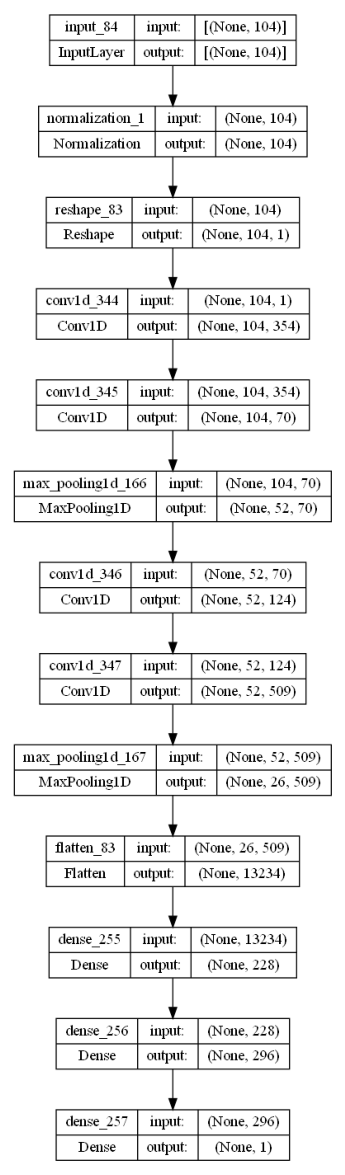

In [51]:
def create_model(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
    batch_size = trial.suggest_categorical("batch_size", [4, 64])

    n_1_layers = trial.suggest_int("n_layers", 1, 3)
    n_2_layers = trial.suggest_int("n_layers", 1, 3)
    n_layers_dense = trial.suggest_int("n_layers", 1, 3)

    model = models.Sequential()
    model.add(layers.Input(shape=(x_train.shape[1],)))
    model.add(normalizer)
    model.add(layers.Reshape((x_train.shape[1], 1)))

    for i in range(n_1_layers):
        num_neurons_conv_1 = trial.suggest_int(f"n_1_units_l_{i}", 64, 512, log=True)
        model.add(tf.keras.layers.Conv1D(num_neurons_conv_1, 1, activation="relu")),

    model.add(layers.MaxPooling1D())

    for i in range(n_2_layers):
        num_neurons_conv_2 = trial.suggest_int(f"n_2_units_l_{i}", 64, 512, log=True)
        model.add(tf.keras.layers.Conv1D(num_neurons_conv_2, 1, activation="relu")),
    model.add(layers.MaxPooling1D())

    model.add(layers.Flatten())

    for i in range(n_layers_dense):
        num_neurons_dense = trial.suggest_int(f"n_3_units_l_{i}", 64, 512, log=True)
        layers.Dropout(dropout_rate),
        model.add(tf.keras.layers.Dense(num_neurons_dense, activation="relu")),

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    # Return the validation loss
    return model


model = create_model(study.best_trial)

model.save("../../models/optimizers/hyperparam_best_model.h5")

# Plot model architecture
from tensorflow.keras.utils import plot_model

plot_file = "../../models/optimizers/hyperparam_model.png"
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the model plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))
img = plt.imread(plot_file)
plt.imshow(img)
plt.axis("off")
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix
def calculate_confusion_matrix(model, X_test, y_test, threshold=0.5):

    # Przewidzenie prawdopodobieństw dla zbioru testowego
    y_pred_prob = model.predict(X_test)
    
    # Konwersja prawdopodobieństw na dyskretne etykiety klas
    if y_pred_prob.shape[1] > 1:  # Problem wieloklasowy
        y_pred = y_pred_prob.argmax(axis=1)
    else:  # Problem binarny
        y_pred = (y_pred_prob >= threshold).astype(int).flatten()
    
    # Obliczenie macierzy konfuzji
    cm = confusion_matrix(y_test, y_pred)
    
    # Wyświetlenie macierzy konfuzji
    print("Macierz konfuzji:")
    print(cm)
    
    return cm

calculate_confusion_matrix(model, x_test, y_test)

1/1 [==============================] - 0s 93ms/step
Macierz konfuzji:
[[ 3  5]
 [ 1 18]]


array([[ 3,  5],
       [ 1, 18]], dtype=int64)